# Fine Tuning XGBoost Parameters
This kernel will try to introduce you to regression with XGBoost and how to fine-tune its parameters for better results.

The following kernels were a huge help and I took some code snippets from them:
- [Regression to Predict House Prices by Elie Kawerk](https://www.kaggle.com/eliekawerk/regression-to-predict-house-prices)
- [Blending of 6 Models (Top 4%) by Sandeep Kumar](https://www.kaggle.com/sandeepkumar121995/blending-of-6-models-top-10)
- [Regularized Linear Models by Alexandru Papiu](https://www.kaggle.com/apapiu/regularized-linear-models)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

#ML
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from lightgbm import LGBMRegressor, plot_importance # LGBM

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import datetime
import time
import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [3]:
# Load data and display info dataset
#df_train = pd.read_csv("../input/train.csv", index_col = 0) 
#df_test = pd.read_csv("../input/test.csv", index_col = 0) 

df_train = pd.read_csv("~/datasets/HP-ART//train.csv", index_col = 0) 
df_test = pd.read_csv("~/datasets/HP-ART//test.csv", index_col = 0) 

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

# Preprocessing

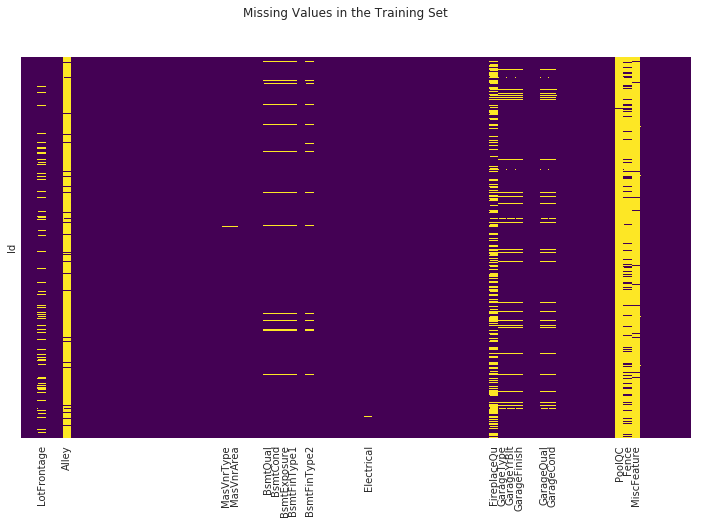

In [5]:
#display Missing values
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [6]:
#remove columns with too many missed values
null_values_per_col = np.sum(df_train.drop(["SalePrice"], axis=1).isnull(), axis=0)
max_na = int(df_train.shape[0]/3.0) #allowing up to 1/3 of the data to be missing
cols_to_remove = []

for col in df_train.drop(["SalePrice"],axis=1).columns.tolist():
    if null_values_per_col[col] > max_na: 
        cols_to_remove.append(col)
        df_train.drop(col, axis=1, inplace=True)
        
print("New shape of the training set is: (%d,%d)" %df_train.shape)        
print("The removed columns are: " + str(cols_to_remove))

#do the same for test dataset
df_test.drop(cols_to_remove, axis=1, inplace=True)

New shape of the training set is: (1460,75)
The removed columns are: ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [7]:
#remap some columns to have numerical data
rep_map_1 = {"NA": 0, "Po": 1,
             "Fa": 2, "TA": 3, 
             "Gd": 4, "Ex": 5,}

rep_map_2 = {"NA": 0, "No": 1,
             "Mn": 2, "Av": 3, 
             "Gd": 4,}

rep_map_3 = {"NA": 0, "Unf": 1,
             "LwQ": 2, "Rec": 3, 
             "BLQ": 4, "ALQ": 5,
             "GLQ": 6,}

rep_map_4 = {"NA": 0, "MnWw": 1,
             "GdWo": 2, "MnPrv": 3, 
             "GdPrv": 4,}

scale_list_1 = ["ExterCond", "BsmtCond", "HeatingQC", "KitchenQual", "GarageCond"]
scale_list_2 = ["BsmtFinType1"]
scale_list_3 = ["BsmtFinType2"]
scale_list_4 = ["Fence"]

In [8]:
for s in scale_list_1:
    df_train = df_train.replace({s:rep_map_1,})
    df_test = df_test.replace({s:rep_map_1,})

df_train = df_train.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

df_test = df_test.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

In [9]:
#Correlation matrix
corr_mat = df_train.drop(columns=["SalePrice"]).corr().abs()

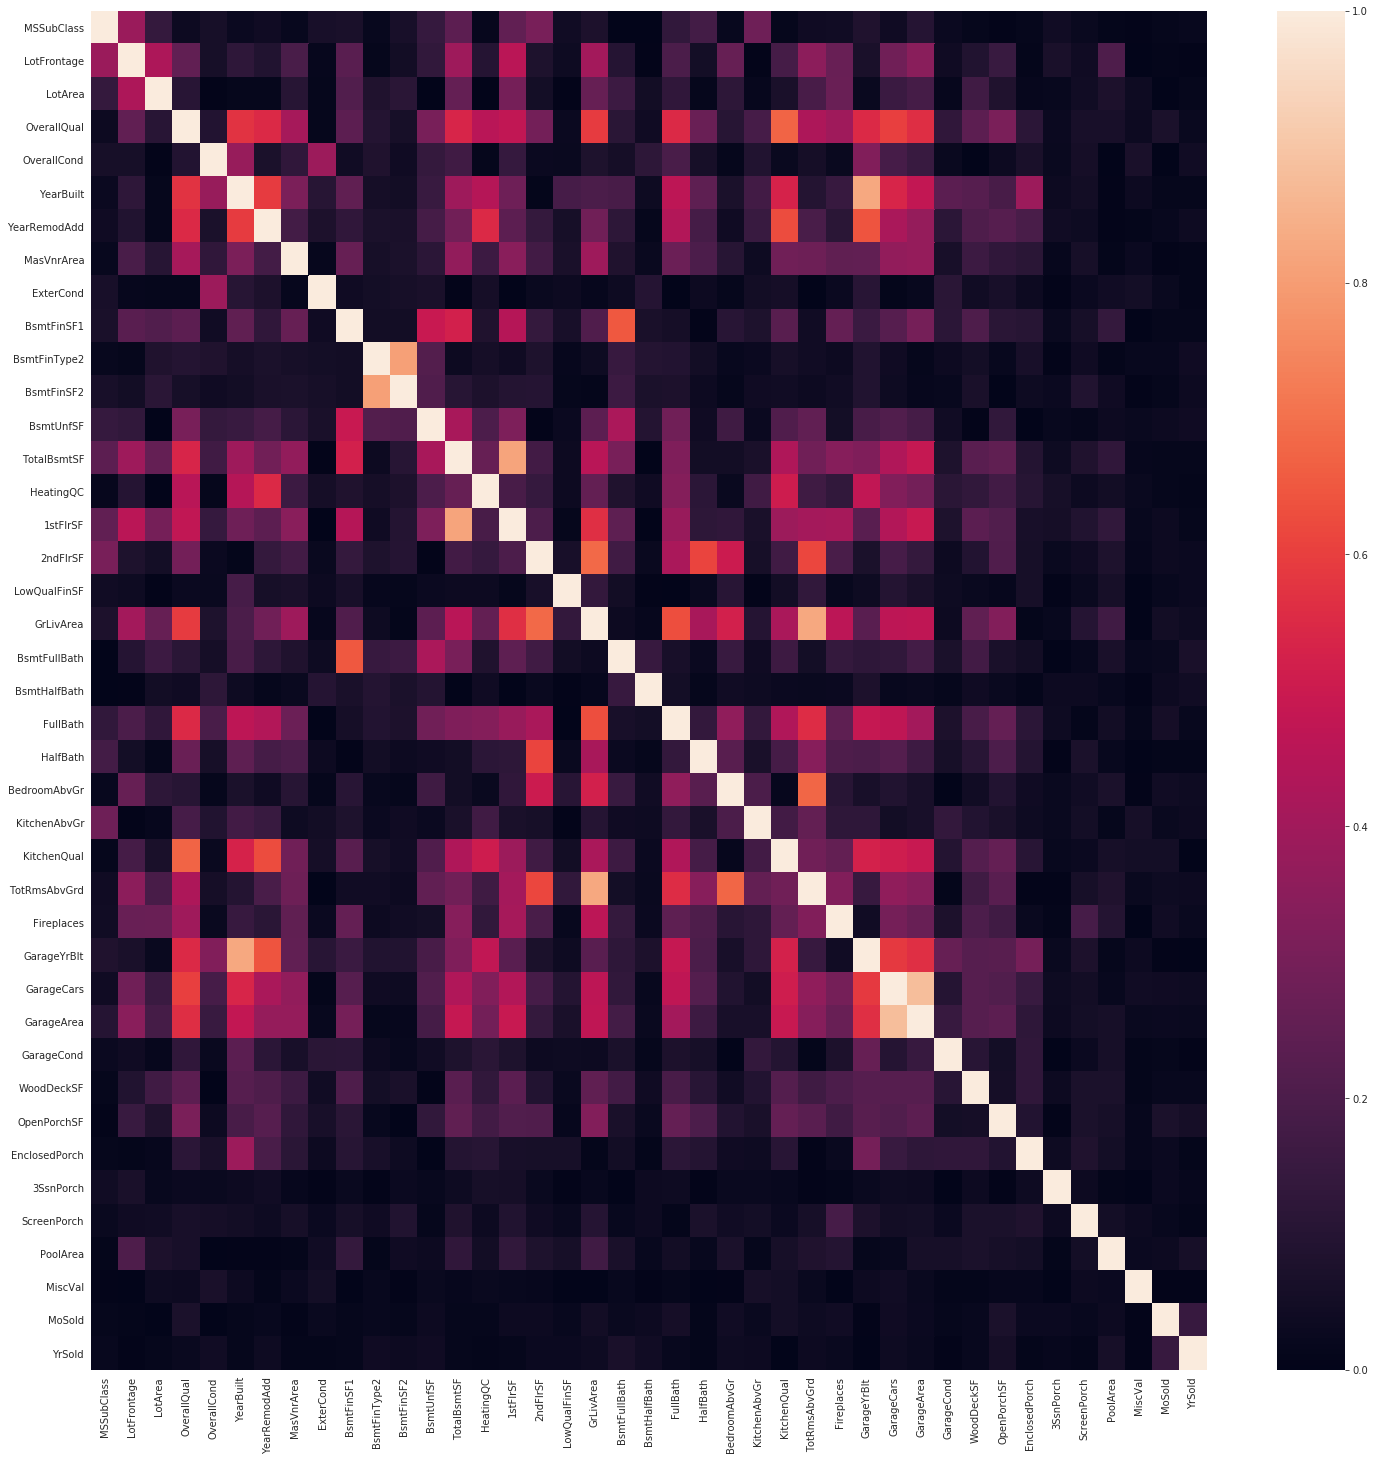

In [10]:
#Plot the heatmap with seaborn
plt.figure(figsize=(25,25)) 
sns.heatmap(corr_mat, 
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

In [11]:
#List the highly correlated columns
corr_tmp = corr_mat.unstack()
corr_tmp = corr_tmp.sort_values(kind="quicksort")

print(corr_tmp[-len(corr_mat)-20:-len(corr_mat)])

YearRemodAdd  GarageYrBlt     0.642277
GarageYrBlt   YearRemodAdd    0.642277
BsmtFullBath  BsmtFinSF1      0.649212
BsmtFinSF1    BsmtFullBath    0.649212
KitchenQual   OverallQual     0.673331
OverallQual   KitchenQual     0.673331
BedroomAbvGr  TotRmsAbvGrd    0.676620
TotRmsAbvGrd  BedroomAbvGr    0.676620
2ndFlrSF      GrLivArea       0.687501
GrLivArea     2ndFlrSF        0.687501
BsmtFinSF2    BsmtFinType2    0.805212
BsmtFinType2  BsmtFinSF2      0.805212
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
dtype: float64


In [12]:
#Remove highly correlated columns if needed, I will skip that
rm_corr = False
if rm_corr:
    columns_corr = ["GarageYrBlt", "GarageCars", "GrLivArea"]
    df_train = df_train.drop(columns=columns_corr)
    df_test = df_test.drop(columns=columns_corr)

In [13]:
#Get a list of all categorical features
categorical_list = []

for col in df_train.columns.tolist():
    if df_train[col].dtype == 'object':
        categorical_list.append(col)

In [14]:
#Convert categorical variables into dummy/indicator variables
df_train = pd.get_dummies(df_train, columns=categorical_list)
df_test = pd.get_dummies(df_test, columns=categorical_list)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 251 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(5), int64(37), uint8(209)
memory usage: 788.5 KB


In [15]:
#If you chose to leave out some columns, remove them now
for col in df_train.columns.tolist():
    if df_train[col].dtype == 'object':
        del df_train[col]
        del df_test[col]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 251 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(5), int64(37), uint8(209)
memory usage: 788.5 KB


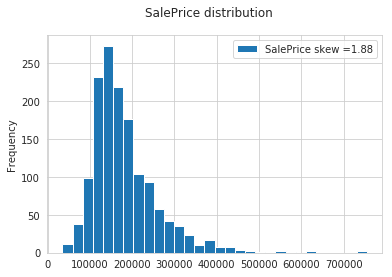

In [16]:
#Check the skewness of SalePrice
skewness = df_train['SalePrice'].skew()
df_train['SalePrice'].plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

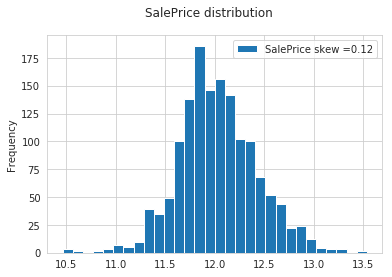

In [17]:
#Apply log1p to reduce skewness
skewness = np.log1p(df_train['SalePrice']).skew()
np.log(df_train['SalePrice']).plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

del skewness

In [18]:
train_stats = df_train.describe()
train_stats

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,3.083562,443.639726,...,0.003425,0.083562,0.002055,0.867808,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,0.351054,456.098091,...,0.058440,0.276824,0.045299,0.338815,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,3.000000,383.500000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,3.000000,712.250000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5.000000,5644.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#prepare for splitting and normalization
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
df_train_tmp = df_train.drop(columns=["SalePrice"]) #Normalize across the whole training dataset

def norm(x):
    #return (x - train_stats['mean']) / train_stats['std']
    return (x - df_train_tmp.mean()) / (df_train_tmp.max() - df_train_tmp.min())

In [20]:
#Normalise, split Z and Y, split data into 80% training and 20% validation set
y_full = df_train.pop('SalePrice')
X_full = norm(df_train)
X_test = norm(df_test)

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=123)

# Parameter Tuning

In [21]:
#Cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
#Function to quickly recreate the model when needed
def model_eval():
    model = XGBRegressor(learning_rate=0.01, #dflt 0.1
                         verbosity = 3, 
                         objective='reg:linear',
                         n_jobs=-1,
                         subsample=0.7,
                         colsample_bytree=0.35,
                         approx='gpu_hist', #use GPU instead of CPU if available
                         random_state=123)
    return model

In [22]:
# 1: optimise n_estimators and max_depth
# the range to explore depends on the problem, and your observations while trying 
# for the meaning of each parameter, check the official documentation https://xgboost.readthedocs.io/en/latest/parameter.html
n_estimators = range(4000, 8001, 500)
max_depth = range(4,7,2)
# create dictionary with the parameters
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
print("number of combinations: {}".format(len(n_estimators)*len(max_depth)))

number of combinations: 18


In [23]:
#fine tune the model
model = model_eval()
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X_full, y_full)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.4min finished
/home/husmen/miniconda3/envs/tf2/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/husmen/miniconda3/envs/tf2/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [24]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.014277 using {'max_depth': 4, 'n_estimators': 6000}
-0.014317 (0.002057) with: {'max_depth': 4, 'n_estimators': 4000}
-0.014306 (0.002052) with: {'max_depth': 4, 'n_estimators': 4500}
-0.014291 (0.002043) with: {'max_depth': 4, 'n_estimators': 5000}
-0.014279 (0.002036) with: {'max_depth': 4, 'n_estimators': 5500}
-0.014277 (0.002038) with: {'max_depth': 4, 'n_estimators': 6000}
-0.014284 (0.002038) with: {'max_depth': 4, 'n_estimators': 6500}
-0.014281 (0.002042) with: {'max_depth': 4, 'n_estimators': 7000}
-0.014283 (0.002037) with: {'max_depth': 4, 'n_estimators': 7500}
-0.014286 (0.002038) with: {'max_depth': 4, 'n_estimators': 8000}
-0.014814 (0.001856) with: {'max_depth': 6, 'n_estimators': 4000}
-0.014811 (0.001853) with: {'max_depth': 6, 'n_estimators': 4500}
-0.014811 (0.001853) with: {'max_depth': 6, 'n_estimators': 5000}
-0.014811 (0.001852) with: {'max_depth': 6, 'n_estimators': 5500}
-0.014812 (0.001850) with: {'max_depth': 6, 'n_estimators': 6000}
-0.014811 (0.00

Text(0, 0.5, 'MSE')

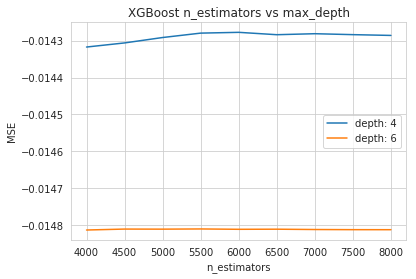

In [25]:
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.title("XGBoost n_estimators vs max_depth")
plt.xlabel('n_estimators')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

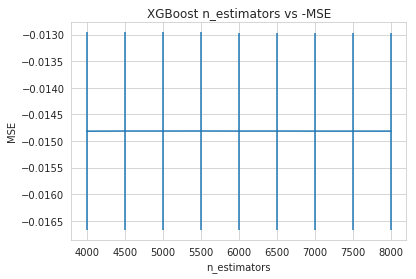

In [26]:
#plot n_estimators with its standard deviation
scores_1 = np.array(means).reshape(len(max_depth), len(n_estimators))
scores_2 = np.array(stds).reshape(len(max_depth), len(n_estimators))

plt.errorbar(n_estimators, scores_1[1], yerr=scores_2[1])
plt.title("XGBoost n_estimators vs -MSE")
plt.xlabel('n_estimators')
plt.ylabel('MSE')

In [27]:
# 2: add min_child_weight parameter
# we could have done this from the beginning, but I wanted to show some graphs above first
n_estimators = [6000]
max_depth = [3, 4]
min_child_weight = range(2, 4, 1)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight)
print("number of combinations: {}".format(len(n_estimators)*len(max_depth)*len(min_child_weight)))

number of combinations: 4


In [28]:
model = model_eval()
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X_full, y_full)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.014063 using {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 6000}
-0.014091 (0.001813) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 6000}
-0.014063 (0.001731) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 6000}
-0.014322 (0.001777) with: {'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 6000}
-0.014153 (0.001680) with: {'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000}


In [55]:
# 3: add gamma, reg_alpha and reg_lambda, 
n_estimators = [6000]
max_depth = [4]
min_child_weight = [3]
gamma = np.arange(0, 0.00001, 0.00002)
reg_alpha = np.arange(0.00000, 0.00011, 0.00002)
reg_lambda= np.arange(1, 0.99989, -0.00002)

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_child_weight = min_child_weight,
                  gamma = gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
print("number of combinations: {}".format(len(gamma)*len(reg_alpha)*len(reg_lambda)))

number of combinations: 36


In [56]:
model = model_eval()
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X_full, y_full)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 23.1min finished


In [57]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.014269 using {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000, 'reg_alpha': 6.000000000000001e-05, 'reg_lambda': 0.99998}
-0.014349 (0.001643) with: {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000, 'reg_alpha': 0.0, 'reg_lambda': 1.0}
-0.014340 (0.001642) with: {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000, 'reg_alpha': 0.0, 'reg_lambda': 0.99998}
-0.014310 (0.001623) with: {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000, 'reg_alpha': 0.0, 'reg_lambda': 0.99996}
-0.014315 (0.001626) with: {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000, 'reg_alpha': 0.0, 'reg_lambda': 0.9999399999999999}
-0.014333 (0.001618) with: {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000, 'reg_alpha': 0.0, 'reg_lambda': 0.9999199999999999}
-0.014341 (0.001618) with: {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 6000, 'r

# Training

In [21]:
# final model with tuned parameters
model = LGBMRegressor(objective='regression',
                       num_leaves=31, #dflt 31
                       learning_rate=0.01,
                       n_estimators=2000,
                       max_bin = 63,
                       bagging_freq = 5,
                       bagging_fraction = 0.7, #subsample 0.8
                       feature_fraction = 0.35, #colsample_bytree 0.2319 
                       min_data_in_leaf = 6, #dflt = 20 
                       min_sum_hessian_in_leaf = 1, #min_child_weight, dflt 1e-3
                       device_type='cpu', #gpu was slower than cpu for some reason!
                       random_state=123)

In [22]:
# final Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
results = cross_val_score(model, X_full, y_full, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


In [23]:
# CV results
results_rmsle = np.sqrt(-results)
print("-MSE: {} ({})".format(results.mean(),results.std()))
print("RMS(L)E: {} ({})".format(results_rmsle.mean(),results_rmsle.std()))

-MSE: -0.015306084406297346 (0.0021997813200194385)
RMS(L)E: 0.12339500352050559 (0.008930706157508479)


In [24]:
#Final training
tick=time.time()

fitted_model = model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         eval_metric='rmse', # Equivalent to RMSLE since we have log1p(SalePrice)
                         early_stopping_rounds=100,
                         verbose=True)

print("Duration: {}s".format(time.time()-tick))

[1]	valid_0's rmse: 0.382453	valid_0's l2: 0.146271
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.379383	valid_0's l2: 0.143931
[3]	valid_0's rmse: 0.376575	valid_0's l2: 0.141809
[4]	valid_0's rmse: 0.373721	valid_0's l2: 0.139667
[5]	valid_0's rmse: 0.370796	valid_0's l2: 0.13749
[6]	valid_0's rmse: 0.368086	valid_0's l2: 0.135487
[7]	valid_0's rmse: 0.3653	valid_0's l2: 0.133444
[8]	valid_0's rmse: 0.362345	valid_0's l2: 0.131294
[9]	valid_0's rmse: 0.359329	valid_0's l2: 0.129118
[10]	valid_0's rmse: 0.356561	valid_0's l2: 0.127136
[11]	valid_0's rmse: 0.353902	valid_0's l2: 0.125246
[12]	valid_0's rmse: 0.351337	valid_0's l2: 0.123438
[13]	valid_0's rmse: 0.349091	valid_0's l2: 0.121864
[14]	valid_0's rmse: 0.346551	valid_0's l2: 0.120098
[15]	valid_0's rmse: 0.344036	valid_0's l2: 0.11836
[16]	valid_0's rmse: 0.341231	valid_0's l2: 0.116438
[17]	valid_0's rmse: 0.338634	valid_0's l2: 0.114673
[18]	valid_0's rmse: 0.336301	valid_0's l2: 0.113

[224]	valid_0's rmse: 0.133735	valid_0's l2: 0.017885
[225]	valid_0's rmse: 0.133426	valid_0's l2: 0.0178024
[226]	valid_0's rmse: 0.133114	valid_0's l2: 0.0177194
[227]	valid_0's rmse: 0.132895	valid_0's l2: 0.0176612
[228]	valid_0's rmse: 0.132588	valid_0's l2: 0.0175795
[229]	valid_0's rmse: 0.132391	valid_0's l2: 0.0175274
[230]	valid_0's rmse: 0.132113	valid_0's l2: 0.0174538
[231]	valid_0's rmse: 0.131858	valid_0's l2: 0.0173865
[232]	valid_0's rmse: 0.131684	valid_0's l2: 0.0173407
[233]	valid_0's rmse: 0.131456	valid_0's l2: 0.0172807
[234]	valid_0's rmse: 0.131196	valid_0's l2: 0.0172124
[235]	valid_0's rmse: 0.130954	valid_0's l2: 0.017149
[236]	valid_0's rmse: 0.130746	valid_0's l2: 0.0170944
[237]	valid_0's rmse: 0.130564	valid_0's l2: 0.0170469
[238]	valid_0's rmse: 0.130345	valid_0's l2: 0.0169898
[239]	valid_0's rmse: 0.130148	valid_0's l2: 0.0169384
[240]	valid_0's rmse: 0.129928	valid_0's l2: 0.0168813
[241]	valid_0's rmse: 0.129712	valid_0's l2: 0.0168251
[242]	valid_

[424]	valid_0's rmse: 0.111851	valid_0's l2: 0.0125106
[425]	valid_0's rmse: 0.111794	valid_0's l2: 0.0124979
[426]	valid_0's rmse: 0.11179	valid_0's l2: 0.0124971
[427]	valid_0's rmse: 0.111785	valid_0's l2: 0.012496
[428]	valid_0's rmse: 0.111762	valid_0's l2: 0.0124908
[429]	valid_0's rmse: 0.111772	valid_0's l2: 0.0124929
[430]	valid_0's rmse: 0.111746	valid_0's l2: 0.0124873
[431]	valid_0's rmse: 0.1117	valid_0's l2: 0.012477
[432]	valid_0's rmse: 0.111659	valid_0's l2: 0.0124678
[433]	valid_0's rmse: 0.111619	valid_0's l2: 0.0124588
[434]	valid_0's rmse: 0.111585	valid_0's l2: 0.0124512
[435]	valid_0's rmse: 0.111559	valid_0's l2: 0.0124454
[436]	valid_0's rmse: 0.111538	valid_0's l2: 0.0124408
[437]	valid_0's rmse: 0.111499	valid_0's l2: 0.0124321
[438]	valid_0's rmse: 0.111474	valid_0's l2: 0.0124266
[439]	valid_0's rmse: 0.111413	valid_0's l2: 0.0124128
[440]	valid_0's rmse: 0.111357	valid_0's l2: 0.0124003
[441]	valid_0's rmse: 0.111311	valid_0's l2: 0.0123902
[442]	valid_0's

[584]	valid_0's rmse: 0.108978	valid_0's l2: 0.0118763
[585]	valid_0's rmse: 0.108985	valid_0's l2: 0.0118776
[586]	valid_0's rmse: 0.108987	valid_0's l2: 0.0118781
[587]	valid_0's rmse: 0.108947	valid_0's l2: 0.0118694
[588]	valid_0's rmse: 0.108902	valid_0's l2: 0.0118597
[589]	valid_0's rmse: 0.108904	valid_0's l2: 0.0118601
[590]	valid_0's rmse: 0.10892	valid_0's l2: 0.0118635
[591]	valid_0's rmse: 0.108907	valid_0's l2: 0.0118607
[592]	valid_0's rmse: 0.108882	valid_0's l2: 0.0118552
[593]	valid_0's rmse: 0.108904	valid_0's l2: 0.0118602
[594]	valid_0's rmse: 0.108895	valid_0's l2: 0.0118581
[595]	valid_0's rmse: 0.108911	valid_0's l2: 0.0118616
[596]	valid_0's rmse: 0.108895	valid_0's l2: 0.011858
[597]	valid_0's rmse: 0.108875	valid_0's l2: 0.0118538
[598]	valid_0's rmse: 0.108856	valid_0's l2: 0.0118496
[599]	valid_0's rmse: 0.108865	valid_0's l2: 0.0118515
[600]	valid_0's rmse: 0.10889	valid_0's l2: 0.011857
[601]	valid_0's rmse: 0.10889	valid_0's l2: 0.0118571
[602]	valid_0's

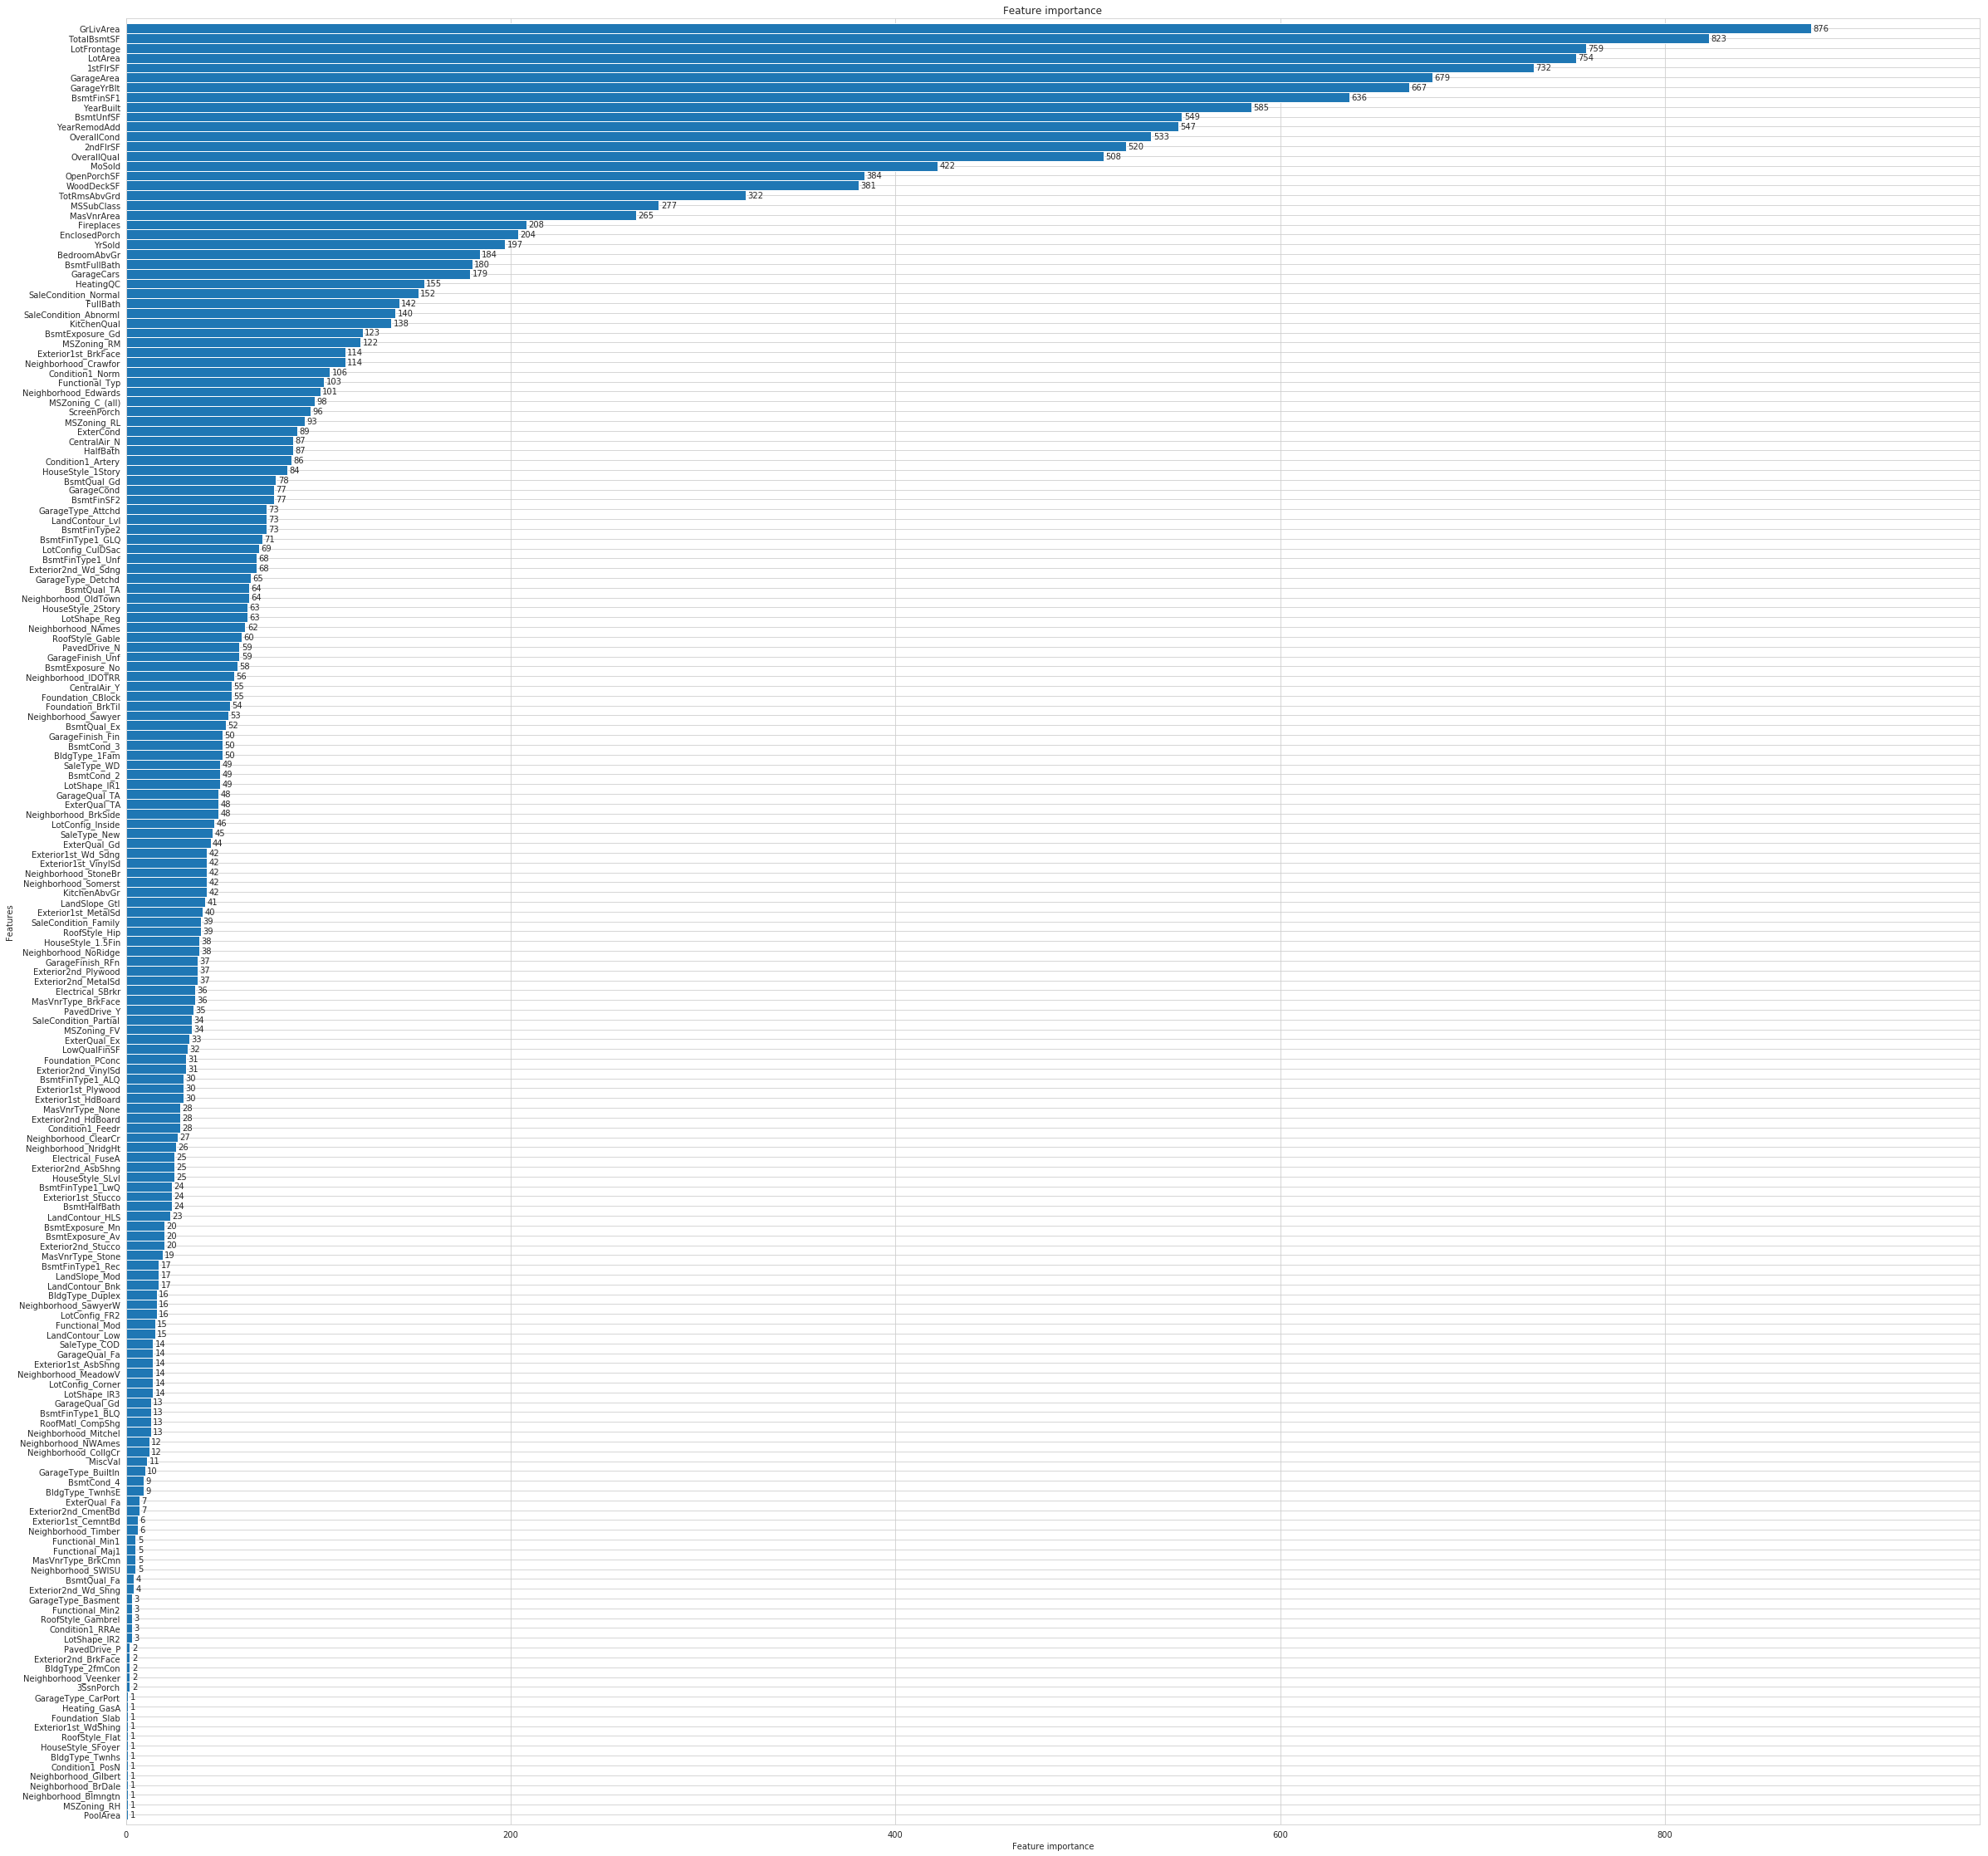

In [25]:
# Plot feature importance
figsize=(40,40)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)

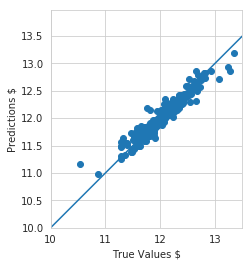

In [26]:
# predict sales in validation dataset
val_predictions = model.predict(X_val).flatten()

# scatter plot of True vs Predicted values
plt.scatter(y_val, val_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,plt.xlim()[1]])
plt.ylim([10,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

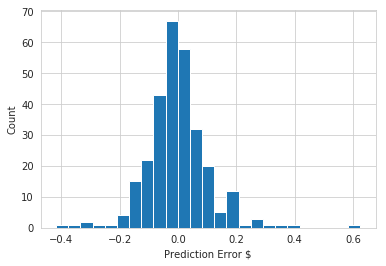

In [27]:
# Histogram of error values
error = val_predictions - y_val
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $")
_ = plt.ylabel("Count")

# Submission

In [37]:
# predict sales for test dataset
predictions = model.predict(X_test[X_train.columns]) # keep columns in same order
# reverse log1p, and round results
predictions = np.round(np.exp(predictions)-1)
print(predictions)

[124976. 164728. 183773. ... 169465. 117424. 228574.]


In [38]:
# prepare dataframe to submit
submission = pd.DataFrame({'Id': df_test.index, 'SalePrice': predictions})
submission.head()

,Id,SalePrice
0,1461,124976.0
1,1462,164728.0
2,1463,183773.0
3,1464,194574.0
4,1465,186951.0


In [41]:
# submit
t_stamp = str(datetime.datetime.now())
t1 = t_stamp.split(" ")[0]
t2 = t_stamp.split(" ")[1].split(".")[0]
submission.to_csv('lgbm2_{}_{}_{}.csv'.format(t1, t2, round(results_rmsle.mean(),5)), index=False)